In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, sin, exp, pi
from itertools import combinations_with_replacement
from functools import reduce
import seaborn as sns
from collections import OrderedDict

from layers.activation.tangent import Tangent
from layers.base.affine import Affine
from layers.loss.squared_error import SquaredError
from layers.optimizer.adam import Adam

In [2]:

poly = lambda x:x*x
sinusoidal = lambda x:sin(pi*x)
absolute = lambda x:abs(x)
step = lambda x:0.5 * (np.sign(x)+1)
funcs = [poly, sinusoidal, absolute, step]

In [3]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 値を元に戻す
        it.iternext()

    return grad


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Tangent1'] = Tangent()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SquaredError()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        for layer in self.layers.values():
            x = layer.forward(x)
        return self.lastLayer.forward(x, t)

    def numerical_gradient(self, x, t):
        loss_W = lambda W:self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        #forward
        self.loss(x, t)

        #backward
        dout = 1
        dout = self.lastLayer.backward()

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

## 5.1 フィードフォワードネットワーク関数

In [4]:
N_train = 40
N_test = 100
x_train = 2 * np.random.rand(N_train) - 1
x_test = np.linspace(-1, 1, N_test)
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

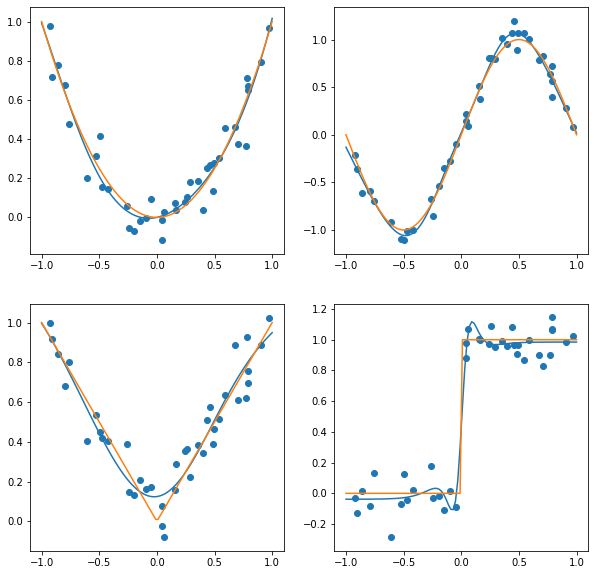

In [5]:
plt.figure(figsize=(10, 10))

max_epoch = 20000
input_size = 1
hidden_size = 3
output_size = 1
optimizer = Adam()
for i, func in zip(range(1, 5), funcs):
    t_train = func(x_train) + np.random.normal(0, 0.1, (N_train, 1))
    t_test = func(x_test)
    model = TwoLayerNet(input_size, hidden_size, output_size)

    for epoch in range(max_epoch):
        grad = model.gradient(x_train, t_train)
        optimizer.update(model.params, grad)
        loss = model.loss(x_train, t_train)
    y = model.predict(x_test)
    plt.subplot(2, 2, i)
    plt.plot(x_test, y)
    plt.plot(x_test, t_test)
    plt.scatter(x_train, t_train)

## 5.5 ニューラルネットワークの正則化

In [6]:
N_train = 10
N_test = 100
x_train = np.linspace(-1, 1, N_train)
x_test = np.linspace(-1, 1, N_test)
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

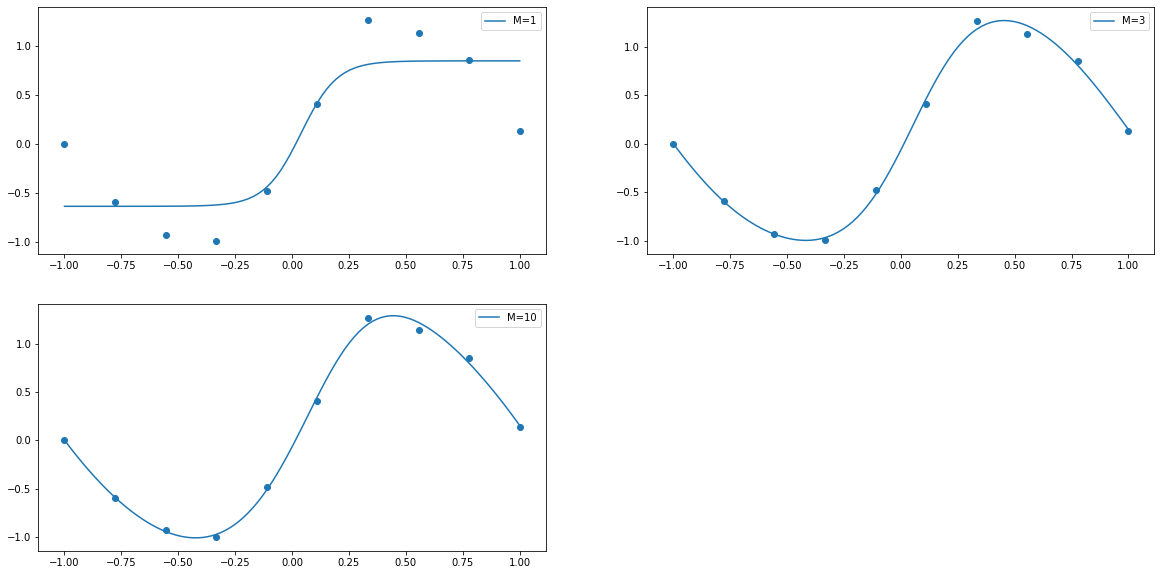

In [7]:
plt.figure(figsize=(20, 10))

max_epoch = 10000
input_size = 1
output_size = 1

t_train = sinusoidal(x_train) + np.random.normal(0, 0.2, (N_train, 1))
t_test = sinusoidal(x_test)
for i, hidden_size in zip(range(1, 4), [1, 3, 10]):
    model = TwoLayerNet(input_size, hidden_size, output_size)
    optimizer = Adam()
    for epoch in range(max_epoch):
        grad = model.gradient(x_train, t_train)
        optimizer.update(model.params, grad)
        loss = model.loss(x_train, t_train)
    y = model.predict(x_test)
    plt.subplot(2, 2, i)
    plt.plot(x_test, y, label=f'M={hidden_size}')
    plt.scatter(x_train, t_train)
    plt.legend()

荷重減衰

In [8]:
class RegularizedTwoLayerNet(TwoLayerNet):
    def __init__(self, input_size, hidden_size, output_size, weight_decay_lambda=0):
        super().__init__(input_size, hidden_size, output_size)
        self.weight_decay_lambda = weight_decay_lambda

    def loss(self, x, t):
        y = self.predict(x)
        reg_term = 0
        for i in range(1, 3):
            W = self.params[f'W{i}']
            reg_term += self.weight_decay_lambda / 2 * W.T @ W
        return self.lastLayer.forward(y, t) + reg_term

    def gradient(self, x, t):
        #forward
        self.loss(x, t)

        #backward
        dout = 1
        dout = self.lastLayer.backward(dout)


        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW + \
                      self.weight_decay_lambda * self.layers['Affine1'].W
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW + \
                      self.weight_decay_lambda * self.layers['Affine2'].W
        grads['b2'] = self.layers['Affine2'].db

        return grads


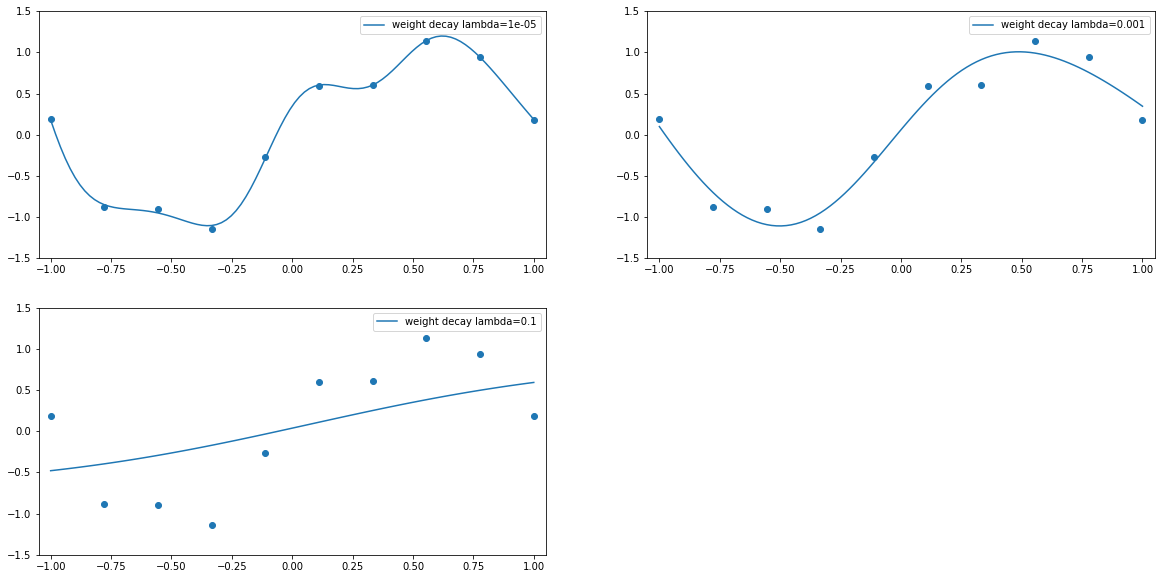

In [9]:
plt.figure(figsize=(20, 10))

max_epoch = 10000
input_size = 1
hidden_size = 30
output_size = 1

t_train = sinusoidal(x_train) + np.random.normal(0, 0.2, (N_train, 1))
t_test = sinusoidal(x_test)
for i, weight_decay_lambda in zip(range(1, 4), [0.00001, 0.001, 0.1]):
    model = RegularizedTwoLayerNet(input_size, hidden_size, output_size, weight_decay_lambda)
    optimizer = Adam()
    for epoch in range(max_epoch):
        grad = model.gradient(x_train, t_train)
        optimizer.update(model.params, grad)
        loss = model.loss(x_train, t_train)
    y = model.predict(x_test)
    plt.subplot(2, 2, i)
    plt.plot(x_test, y, label=f'weight decay lambda={weight_decay_lambda}')
    plt.scatter(x_train, t_train)
    plt.xlim(-1.05, 1.05)
    plt.ylim(-1.5, 1.5)
    plt.legend()


## 5.6 混合密度ネットワーク

C:\Users\Asunaro\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(-0.05, 1.05)

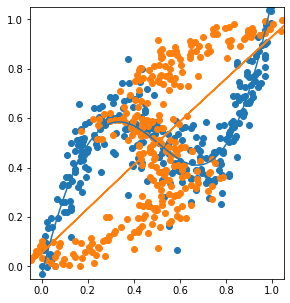

In [10]:
plt.figure(figsize=(10, 5))

N_train = 300
N_test = 300
batch_size = 80

max_epoch = 100000
input_size = 1
hidden_size = 6
output_size = 1

x_train = np.random.rand(N_train).reshape(-1, 1)
x_test = np.linspace(0, 1, N_test).reshape(-1, 1)
t_train = x_train + 0.3 * sinusoidal(2*x_train) + np.random.normal(0, 0.1, (N_train, 1))
t_test = x_test + sinusoidal(2*x_test)
model = TwoLayerNet(input_size, hidden_size, output_size)
optimizer = Adam()
for epoch in range(max_epoch):
    index = np.random.choice(N_train, batch_size, replace=True)
    grad = model.gradient(x_train, t_train)
    optimizer.update(model.params, grad)
y = model.predict(x_test)
plt.subplot(1, 2, 1)
plt.plot(x_test, y)
plt.scatter(x_train, t_train)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)


t_train = np.random.rand(N_train).reshape(-1, 1)
t_test = np.linspace(0, 1, N_test).reshape(-1, 1)
x_train = t_train + 0.3 * sinusoidal(2*t_train) + np.random.normal(0, 0.1, (N_train, 1))
x_test = t_test + sinusoidal(2*t_test)
model = TwoLayerNet(input_size, hidden_size, output_size)
optimizer = Adam()
for epoch in range(max_epoch):
    index = np.random.choice(N_train, batch_size, replace=True)
    grad = model.gradient(x_train, t_train)
    optimizer.update(model.params, grad)
y = model.predict(x_test)
plt.subplot(1, 2, 1)
plt.plot(x_test, y)
plt.scatter(x_train, t_train)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

In [11]:
# 混合密度ネットワークのコスト関数
class MixtureGaussian:
    def __init__(self, components_size):
        self.components_size = components_size
        self.t = None
        self.sigma = None
        self.weight = None
        self.mu = None

    def _gaussian(self, t):
        return np.exp(-0.5 * (self.mu - t) ** 2 / np.square(self.sigma))\
               / np.sqrt(2 * np.pi * np.square(self.sigma))

    def activate(self, x):
        a_sigma, a_weight, a_mu = np.split(
            x, [self.components_size, self.components_size*2], axis=1)

        self.sigma = exp(a_sigma)

        self.weight = exp(a_weight - np.max(a_weight, 1, keepdims=True))
        self.weight /= np.sum(self.weight, axis=1, keepdims=True)

        self.mu = a_mu

        return self.sigma, self.weight, a_mu

    def forward(self, x, t):
        self.t = t
        self.sigma, self.weight, self.mu = self.activate(x)

        gaussian = self._gaussian(self.t)

        return -np.sum(np.log(np.sum(self.weight * gaussian, axis=1)))

    def backward(self):
        gamma = self.weight * self._gaussian(self.t)
        gamma /= np.sum(gamma, axis=1, keepdims=True)

        delta_sigma = gamma * (1 - (self.mu - self.t)**2 / (self.sigma**2))
        delta_weight = self.weight - gamma
        delta_mu = gamma * (self.mu - self.t) / (self.sigma**2)

        delta = np.hstack([delta_sigma, delta_weight, delta_mu])
        return delta

In [12]:
class MixtureDensityNet(TwoLayerNet):
    def __init__(self, input_size, hidden_size, output_size, components_size):
        super().__init__(input_size, hidden_size, output_size)

        self.lastLayer = MixtureGaussian(components_size)

    def predict(self, x, t):
        self.t = t
        for layer in self.layers.values():
            x = layer.forward(x)
        sigma, weight, mu = self.lastLayer.activate(x)
        gauss = self.lastLayer._gaussian(self.t)
        prob = np.sum(weight * gauss, axis=1)
        return prob

In [13]:
max_epoch = 1000000
input_size = 1
hidden_size = 6
output_size = 9
components_size = 3

y_test = np.linspace(t_test.min(), t_test.max(), N_test)
X_test, Y_test = np.meshgrid(x_test, y_test)
test = np.array([X_test, Y_test]).transpose(1, 2, 0).reshape(-1, 2)

model = MixtureDensityNet(input_size, hidden_size, output_size, components_size)
optimizer = Adam()
for epoch in range(max_epoch):
    index = np.random.choice(N_train, batch_size, replace=True)
    grad = model.gradient(x_train[index], t_train[index])
    optimizer.update(model.params, grad)
prob = model.predict(test[:, 0].reshape(-1, 1), test[:, 1].reshape(-1, 1))
Prob = prob.reshape(N_test, N_test)

weight = model.lastLayer.weight
mu = model.lastLayer.mu


(-0.0, 1.0)

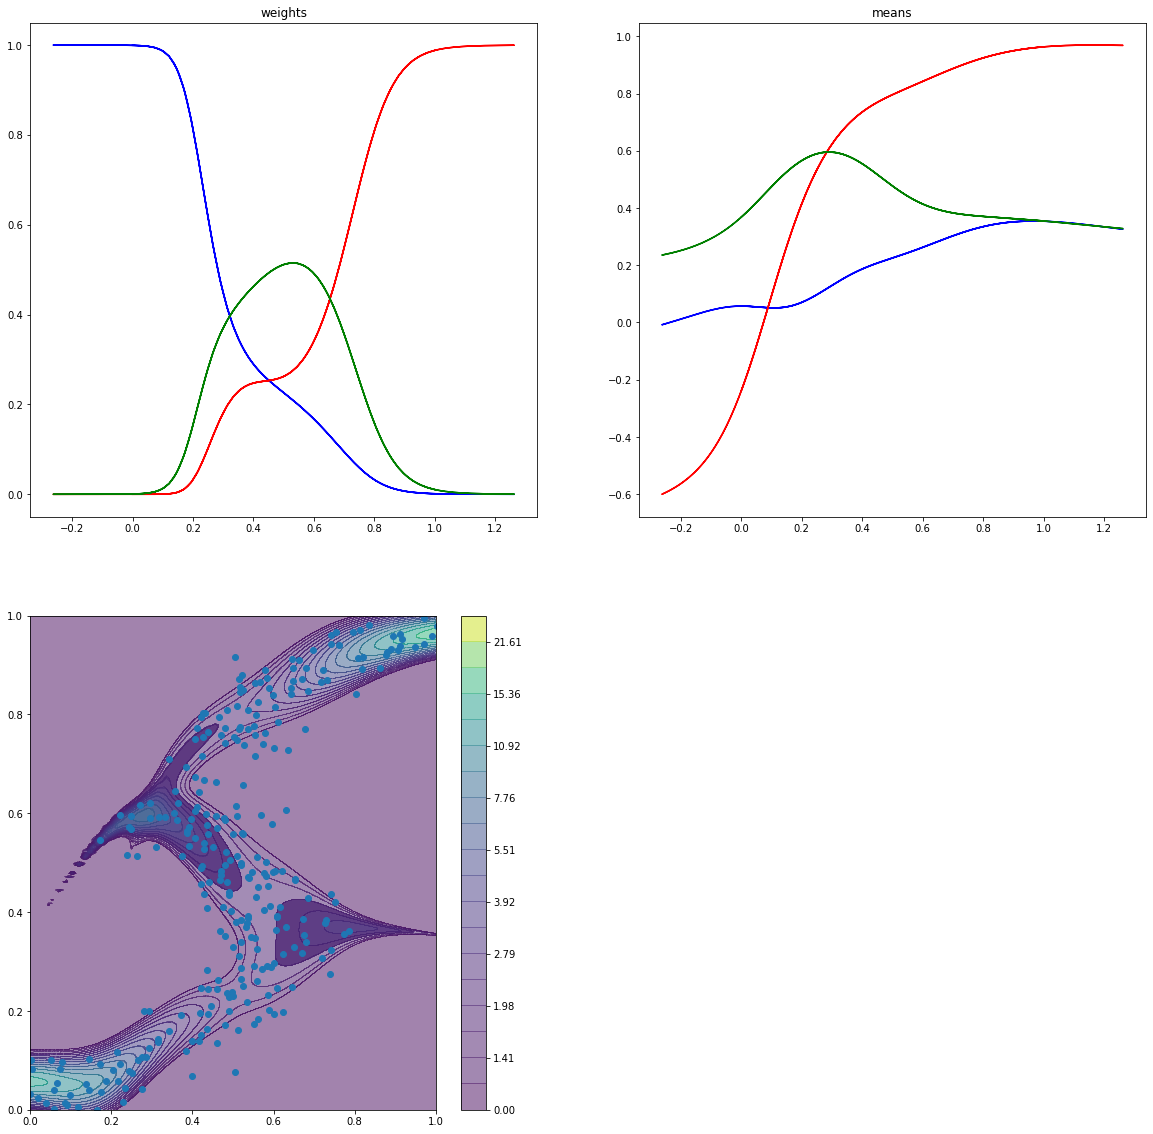

In [14]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.plot(x_test, weight[:N_test, 0], color='blue')
plt.plot(x_test, weight[:N_test, 1], color='red')
plt.plot(x_test, weight[:N_test, 2], color='green')
plt.title('weights')

plt.subplot(2, 2, 2)
plt.plot(x_test, mu[:N_test, 0], color='blue')
plt.plot(x_test, mu[:N_test, 1], color='red')
plt.plot(x_test, mu[:N_test, 2], color='green')
plt.title('means')

plt.subplot(2, 2, 3)
levels = np.exp(np.linspace(0, np.log(prob.max()), 20))
levels[0] = 0
plt.contourf(X_test, Y_test, Prob, levels, alpha=0.5)
plt.colorbar()
plt.scatter(x_train, t_train)
plt.xlim(-0.0, 1.0)
plt.ylim(-0.0, 1.0)